In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import matplotlib.image as mpimg
from tqdm import tqdm
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing import image

%matplotlib inline

Using TensorFlow backend.


In [2]:
def dataset():
    train_dataset = h5py.File('/Users/ananya/Downloads/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) 
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('/Users/ananya/Downloads/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) 
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:]) 

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig,train_set_y,test_set_x_orig,test_set_y,classes =dataset()

In [4]:
train_dataset = h5py.File('/Users/ananya/Downloads/train_catvnoncat.h5', "r")
print(list(train_dataset))
train_dataset['train_set_x'][:]
test_dataset = h5py.File('/Users/ananya/Downloads/test_catvnoncat.h5', "r")
test_dataset['test_set_x'][:]

['list_classes', 'train_set_x', 'train_set_y']


array([[[[158, 104,  83],
         [161, 106,  85],
         [162, 107,  84],
         ...,
         [170, 120, 100],
         [167, 121, 103],
         [172, 127, 109]],

        [[158, 103,  82],
         [160, 104,  82],
         [162, 105,  83],
         ...,
         [169, 118,  99],
         [164, 117,  98],
         [168, 121, 104]],

        [[158, 104,  82],
         [161, 105,  82],
         [162, 105,  83],
         ...,
         [173, 123, 102],
         [169, 122, 104],
         [168, 122, 104]],

        ...,

        [[102,  68,  52],
         [ 44,  31,  23],
         [ 28,  23,  20],
         ...,
         [163, 118, 102],
         [163, 120, 103],
         [166, 121, 105]],

        [[ 99,  67,  51],
         [ 38,  28,  22],
         [ 30,  26,  23],
         ...,
         [161, 117, 100],
         [164, 121, 104],
         [168, 123, 106]],

        [[127,  95,  72],
         [ 39,  29,  22],
         [ 30,  25,  22],
         ...,
         [165, 122, 105],
        

In [29]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]

In [30]:
a=train_set_x_orig.shape
b=test_set_x_orig.shape
c=train_set_y.shape
d=test_set_y.shape
print(a,b,c,d)

(209, 64, 64, 3) (50, 64, 64, 3) (1, 209) (1, 50)


In [31]:
train_flatten = (train_set_x_orig.reshape(a[0], -1).T)/255
test_flatten=(test_set_x_orig.reshape(b[0], -1).T)/255

In [32]:
def sigmoid_fn(z):
    s=1/(1+np.exp(-z))
    return s

In [33]:
def zeroes1(x):
    w = np.array(np.zeros(shape=(x, 1), dtype=np.float32))
    b = 0
    return w,b

In [34]:
w,b=zeroes1(2)
print("w="+str(w),"b="+str(b))

w=[[0.]
 [0.]] b=0


In [35]:
def function1(w,b,X,Y):
    #forward propogation
    m=X.shape[1]
    A = sigmoid_fn(np.dot(w.T, X) + b)             
    cost = (-1. / m) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1) 
    costJ=np.squeeze(cost)
    #backward propogation
    dw = (1./m)*np.dot(X,((A-Y).T))
    db = (1./m)*np.sum(A-Y, axis=1)
    grads={"dw":dw,"db":db}
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    assert(costJ.shape == ())
    return grads,costJ

In [36]:
w, b, X, Y = np.array([[1],[2]]), 2, np.array([[1,2],[3,4]]), np.array([[1,0]])
grads, costJ = function1(w, b, X, Y)

In [37]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs=[]
    for i in range(num_iterations):
        grads, cost = function1(w=w, b=b, X=X, Y=Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate*dw
        b = b -  learning_rate*db
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [38]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

In [39]:
print(params,grads)

{'w': array([[0.1124579 ],
       [0.23106775]]), 'b': array([1.55930492])} {'dw': array([[0.90158428],
       [1.76250842]]), 'db': array([0.43046207])}


In [40]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid_fn(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1
            
        else:
            Y_prediction[0, i] = 0
    return Y_prediction

In [41]:
str(predict(w,b,X))

'[[1. 1.]]'

In [42]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    w, b = zeroes1(X_train.shape[0])

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    

    w = parameters["w"]
    b = parameters["b"]
    

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [43]:
d = model(train_flatten, train_set_y, test_flatten, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %
learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %
learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %


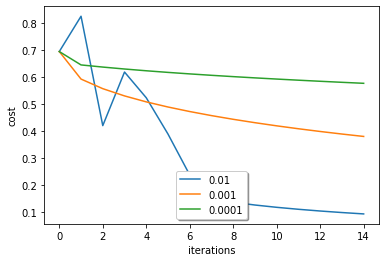

In [44]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_flatten, train_set_y, test_flatten, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='lower center', shadow=True)
plt.show()

0.0 b'non-cat'


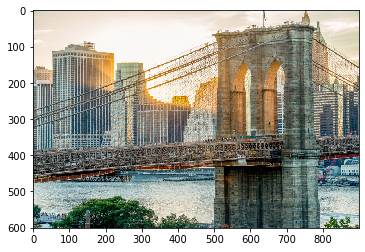

In [45]:
import skimage
my_image = "/Users/ananya/Downloads/bb.jpg"   
image = np.array(plt.imread(my_image))
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
d=str(np.squeeze(my_predicted_image))
s=classes[int(np.squeeze(my_predicted_image))]
print(d,s)